### Machine Learning
This notebook shows our modeling approach using machine learning.

Content:
1. Loading Nielsen's Data
2. Loading the Analytical Base Table
3. Fast Fourier Transformation Function
4. Modeling Function
5. Scenario Analysis

  5.1 Base Case

  5.2 Best Case
  
  5.3 Worst Case

6. Model Evaluation

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import numpy as np
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
import pylab as pl
from numpy import fft
import datetime as dt

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import r2_score
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## 1 - Loading Nielsen's Data
First, we load the data provided by Nielsen and join the different dataframes. 

Next, to make each timeseries more accessible, we pivot the dataframe to have a multi-level column index corresponding to the product group on each hierarchy level. The row index will then only correspond the the timestamp. 

This way, to access one product group, we just select the market and hierarchy level and have the time series that we want. If we need a product group higher hierarchy level, we just add all products that make up this product group. 

The resulting dataframe is shown below.



In [3]:
# load the fact table
filepath_fact = '/content/drive/My Drive/Datathon Term 3/Data/A9002SE2REVSFF_fact_data_05132020.csv'
fact = pd.read_csv(filepath_fact, sep = '|') 

# load dimension table with foreign key MKT_TAG
filepath_dim_mkt = '/content/drive/My Drive/Datathon Term 3/Data/A9002SE2REVSFF_MKT_05132020.csv'
dim_mkt_tag = pd.read_csv(filepath_dim_mkt, sep = '|')

# drop columns with only NAs
dim_mkt_tag.drop(['PARENT_TAG',	'HIER_NUM',	'HIER_NAME',	'HIER_LEVEL_NUM',	'HIER_LEVEL_NAME'],
                 axis = 1,
                 inplace = True)

# load dimension table with foreign key PROD_TAG
filepath_dim_prod = '/content/drive/My Drive/Datathon Term 3/Data/A9002SE2REVSFF_PROD_05132020.csv'
dim_prod_tag = pd.read_csv(filepath_dim_prod, sep = '|')

# load dimension table with foreign key PER_TAG
filepath_dim_per = '/content/drive/My Drive/Datathon Term 3/Data/A9002SE2REVSFF_PER_05132020.csv'
dim_per_tag = pd.read_csv(filepath_dim_per, sep = '|')

# drop columns with only NAs
dim_per_tag.drop(['PARENT_TAG',	'HIER_NUM',	'HIER_NAME',	'HIER_LEVEL_NUM',	'HIER_LEVEL_NAME'],
                 axis = 1,
                 inplace = True)

# load metadata table for names of column of the fact table
filepath_col_desc = '/content/drive/My Drive/Datathon Term 3/Data/A9002SE2REVSFF_FCT_05132020.csv'
fact_col_desc = pd.read_csv(filepath_col_desc, sep = '|')

# merge data
fact = fact.merge(dim_per_tag, left_on='PER_TAG', right_on='TAG', suffixes=('', '_PER'))
fact = fact.merge(dim_prod_tag, left_on='PROD_TAG', right_on='TAG', suffixes = ('', '_PROD'))

# get date in datetime format
fact['DATE'] = fact.LONG.map(lambda string: dt.datetime.strptime(string[14:22], '%d-%m-%y'))

# reshape to table to have market and hierarchy level on a column multi-index
volume = fact.pivot_table(values = 'E', index = 'DATE', columns = ['MKT_TAG', 'SECTOR', 'SECCION', 'CATEGORIA', 'FAMILIA', 'TIPO DE MARCA'])

# remove impact of Covid-19 and replace with average from the two previous years
third_week_march = volume.loc[(volume.index == '2018-03-18') | (volume.index == '2019-03-17'),:].apply('mean')
fourth_week_march = volume.loc[(volume.index == '2018-03-25') | (volume.index == '2019-03-24'),:].apply('mean')

volume.loc[volume.index == '2020-03-15',:] = np.array(third_week_march)
volume.loc[volume.index == '2020-03-22',:] = np.array(fourth_week_march)

# print shape and first 5 rows
print(f'Shape of volume dataframe: {volume.shape}\n\n')
volume.head()

Shape of volume dataframe: (160, 29887)




MKT_TAG                 MTHO7            ...                  MULSC        
SECTOR        ALIM. Y BEBIDAS            ...           PROD.FRESCOS        
SECCION             ALIM.SECA            ...                 QUESOS        
CATEGORIA              ACEITE            ... RESTO QUESOS NATURALES        
FAMILIA             GIRASOL..            ...        RQN.EMPAQUETADO        
TIPO DE MARCA            M.D.      M.F.  ...                   M.D.    M.F.
DATE                                     ...                               
2017-04-16           284826.0   84454.0  ...                  918.0  1289.0
2017-04-23           256410.0   80760.0  ...                  809.0   897.0
2017-04-30           297632.0  101413.0  ...                  883.0  1107.0
2017-05-07           271115.0   94962.0  ...                  774.0   813.0
2017-05-14           261788.0   90573.0  ...                  816.0   900.0

[5 rows x 29887 columns]

## 2 - Loading the Analytical Base Table
In the notebook named Analytical Base Table, we created the analytical base table with all the features common to all models and saved it as a csv file.

Here, we load the csv file into a dataframe called "features" which will be used in all models.

In [4]:
# load the analytical base table
features = pd.read_csv('/content/drive/My Drive/Datathon Term 3/Data/analytical_base_table.csv', index_col = 'DATE')
features

,day,week,month,season,holiday,oil_price,quarterly_unemployment_rate,quarterly_gdp_growth_rate,quarterly_inflation_rate
DATE,,,,,,,,,
2017-04-16,16,15,4,spring,True,51.06,17.535688,3.077982,1.841017
2017-04-23,23,16,4,spring,False,51.06,17.496519,3.077982,1.841017
2017-04-30,30,17,4,spring,False,51.06,17.457350,3.077982,1.841017
2017-05-07,7,18,5,spring,True,48.48,17.418181,3.077982,1.841017
2017-05-14,14,19,5,spring,False,48.48,17.379012,3.077982,1.841017
...,...,...,...,...,...,...,...,...,...
2020-11-29,29,48,11,fall,False,34.50,14.941758,3.881060,-0.374563
2020-12-06,6,49,12,fall,True,35.00,14.941758,3.881060,-0.374563
2020-12-13,13,50,12,fall,True,35.00,14.941758,3.881060,-0.374563


## 3 - Fast Fourier Transformation Function
Next, we define a function that does a Fast Fourier Transformation (FFT) of the timeseries. The FFT decomposes the timeseries into individual sine waves. We keep the 5 sine waves with the highest amplitude and the sum of those as a feature. 

Everytime we selected a timeseries to model, this function needs to be called to create the feature which is added to the dataframe "features".

In [5]:
def fourierExtrapolation(x, n_predict):
    n = x.size
    n_harm = 5                     # number of harmonics in model
    t = np.arange(0, n)
    p = np.polyfit(t, x, 1)         # find linear trend in x
    x_notrend = x - p[0] * t        # detrended x
    x_freqdom = fft.fft(x_notrend)  # detrended x in frequency domain
    f = fft.fftfreq(n)              # frequencies
    indexes = list(range(n))
    # sort indexes by frequency, lower -> higher
    indexes.sort(key=lambda i: np.absolute(x_freqdom[i]))
    indexes.reverse()
 
    t = np.arange(0, n + n_predict)
    restored_sig = np.zeros(t.size)
    for i in indexes[:1 + n_harm * 2]:
        ampli = np.absolute(x_freqdom[i]) / n   # amplitude
        phase = np.angle(x_freqdom[i])          # phase
        restored_sig += ampli * np.cos(2 * np.pi * f[i] * t + phase)
    return restored_sig + p[0] * t

## 4 - Modeling Function
The following is a function that gets the market, hierarchy level, hierarchy name (such as Bebidas or Aceite) as input. It uses these parameters to get the correct timeseries from the pivoted dataframe with the column multi-index we created above.

It also takes a parameter prediction horizon, which specifies whether to test the model on a pre-Covid timeframe, a during Covid timeframe and a forecasting timeframe which is the time until the end of the year.

It also takes the rate at which the effect of Covid will return to normal and in which week (if any) there is a second wave hitting Spain. This is only used if the prediction horizon is set to "forecast", in order to provide different scenarios of what will happen until the end of the year.

Next, a machine learning pipeline is created which one-hot encodes the categorical variables and trains a Ridge regression model with the regularization parameter alpha=1000.

Finally, it predicts on train and test set to return the MAPE for both, as well as a pandas series including all historical data and the forecast.

In [6]:
def predict(market, 
            hierarchy_level, 
            hierarchy_name, 
            prediction_horizon,
            back_to_normal_rate = 0.05,
            week_of_second_wave = None):

  # define a boolean mask based on market and hierarchy level
  mask = (volume.columns.get_level_values(0) == market) & (volume.columns.get_level_values(hierarchy_level) == hierarchy_name)

  # create get the time series for the specified market and hierarchy level combination
  product = volume.iloc[:,mask].apply('sum', axis = 1)

  if prediction_horizon == 'pre_covid':
    train_date = '2019-07-01'
    test_date = '2020-01-01'
  elif prediction_horizon == 'during_covid':
    train_date = '2020-01-01'
    test_date = '2020-05-05'
  elif prediction_horizon == 'forecast':
    train_date = '2020-05-05'
    test_date = '2020-12-31'
  else:
    raise ValueError('Not a valid prediction horizon. Choose between "pre_covid", "during_covid" and "forecast"')

  # create a feature using fourier transformation
  n_predict = features.shape[0] - product.loc[product.index < train_date].shape[0]
  features['fourier_transform'] = fourierExtrapolation(x = product.loc[product.index < train_date].to_numpy(), 
                                                       n_predict = n_predict)

  if prediction_horizon == 'forecast':

    # get the rate of decay of the impact of Covid-19
    if (back_to_normal_rate >= 1) | (back_to_normal_rate <= 0):
      raise ValueError('Parameter back_to_normal_rate must be a float between 0 and 1')
    else:
      decay = 1 - back_to_normal_rate
    
    # get the impact of the first wave that start in the middle of march
    first_wave = (1 * (decay ** (features.week - 13))).to_frame().reset_index()
    first_wave['week_no'] = pd.to_datetime(first_wave.DATE).dt.week
    first_wave['year_no'] = pd.to_datetime(first_wave.DATE).dt.year
    first_wave.rename(columns = {'week' : 'covid_impact'}, inplace = True)

    # get the impact of the second wave, if a second wave is specified
    if week_of_second_wave is not None:
      if (week_of_second_wave <= 52) | (week_of_second_wave >= 26):
        second_wave = (1 * (decay ** (features.week - week_of_second_wave))).to_frame().reset_index()
        second_wave['week_no'] = pd.to_datetime(second_wave.DATE).dt.week
        second_wave['year_no'] = pd.to_datetime(second_wave.DATE).dt.year
        second_wave.rename(columns = {'week' : 'covid_impact'}, inplace = True)
      else:
        raise ValueError('Parameter week_of_second_wave needs to be larger or equal to 26 and smaller or equal to 52')

    # add the impact as a feature
    features['covid_impact'] = 0
    features.loc[(features.week >= 13) & (features.index > '2020-01-01'), 'covid_impact'] = np.array(first_wave.loc[(first_wave.week_no >= 13) & (first_wave.year_no == 2020), 'covid_impact'])
    if week_of_second_wave is not None:
      features.loc[(features.week >= week_of_second_wave) & (features.index > '2020-01-01'), 'covid_impact'] = np.array(second_wave.loc[(second_wave.week_no >= week_of_second_wave) & (second_wave.year_no == 2020), 'covid_impact'])

  # create X_train and y_train
  X_train = features.loc[features.index < train_date,:].copy()
  y_train = product.loc[product.index < train_date].copy()

  # create X_test and y_test 
  X_test = features.loc[(features.index >= train_date) & (features.index < test_date),:].copy()
  y_test = product.loc[(product.index >= train_date) & (product.index < test_date)].copy()

  # create and fit a model
  preprocessing = make_column_transformer((OneHotEncoder(drop = 'first'), ['day', 'week', 'month', 'season', 'holiday']), 
                                          (StandardScaler(), ['oil_price', 'quarterly_unemployment_rate', 'quarterly_gdp_growth_rate', 'quarterly_inflation_rate', 'fourier_transform', 'covid_impact']),
                                          remainder = 'passthrough')
  model = make_pipeline(preprocessing, Ridge(alpha = 10))
  model.fit(X_train, y_train)

  # predict on train and test set
  y_train_pred = model.predict(X_train)
  y_test_pred = model.predict(X_test)

  # evaluate model and return results
  if prediction_horizon != 'forecast':
    # evaluate model
    mape_train = 100 * np.mean(abs(y_train - y_train_pred) / y_train)
    mape_test = 100 * np.mean(abs(y_test - y_test_pred) / y_test)
    mape_test_4 = 100 * np.mean(abs(y_test[:4] - y_test_pred[:4]) / y_test[:4])

    # return results
    metrics = {'MAPE train': mape_train, 'MAPE test (4 weeks)': mape_test_4, 'MAPE test' : mape_test}
    return metrics, y_test_pred

  elif prediction_horizon == 'forecast':
    # evaluate model
    mape_train = 100 * np.mean(abs(y_train - y_train_pred) / y_train)
    
    # return results
    total_timeseries = y_train.append(pd.Series(y_test_pred))
    total_timeseries.index = features.index
    return mape_train, y_test_pred, total_timeseries

## 5 - Scenario Analysis
In the following, we run the predict function for all product groups in the hierarchy level Categoria for the market Espana. 

We then save the predictions in a csv file to be able to use them in the dashboard.

### 5.1 - Base Case
The base case assumes a rate of return to normal of 5% and that there will not be a second wave. 

In [7]:
# create empty dataframe for prediction and metrics
prediction_data = pd.DataFrame(columns=['HIER_LEVEL_NUM', 'NAME', 'DATE', 'TIMESERIES'])
metric_data = pd.DataFrame(columns=['HIER_LEVEL_NUM', 'NAME', 'METRIC'])

# get series to loop over
categorias = pd.Series(fact.CATEGORIA.unique()).dropna()

# loop over the series
for categoria in categorias:

  # run the predict function
  metrics, forecast, total_timeseries = predict('MTHO7', 3, categoria, prediction_horizon='forecast', back_to_normal_rate = 0.05, week_of_second_wave = None)
  
  # add the metrics to the metric_data dataframe
  metrics = pd.DataFrame({'HIER_LEVEL_NUM' : [4], 'NAME' : [categoria], 'METRIC' : [metrics]})
  metric_data = metric_data.append(metrics)

  # add the timeseries data to the prediction_data dataframe
  total_timeseries = total_timeseries.to_frame()
  total_timeseries.columns = ['TIMESERIES']
  total_timeseries['HIER_LEVEL_NUM'] = 4
  total_timeseries['NAME'] = categoria
  total_timeseries.reset_index(inplace = True)

  prediction_data = prediction_data.append(total_timeseries)

# save only the forecast as a csv file
prediction_data.loc[prediction_data.DATE > '2020-05-05',:].to_csv('/content/drive/My Drive/Datathon Term 3/Data/forecast_base_case.csv', index = False)

### 5.2 - Best Case
The best case assumes that the effect of Covid-19 will decline at a rate of 10%.

In [8]:
# create empty dataframe for prediction and metrics
prediction_data = pd.DataFrame(columns=['HIER_LEVEL_NUM', 'NAME', 'DATE', 'TIMESERIES'])
metric_data = pd.DataFrame(columns=['HIER_LEVEL_NUM', 'NAME', 'METRIC'])

# get series to loop over
categorias = pd.Series(fact.CATEGORIA.unique()).dropna()

# loop over the series
for categoria in categorias:

  # run the predict function
  metrics, forecast, total_timeseries = predict('MTHO7', 3, categoria, prediction_horizon='forecast', back_to_normal_rate = 0.10, week_of_second_wave = None)
  
  # add the metrics to the metric_data dataframe
  metrics = pd.DataFrame({'HIER_LEVEL_NUM' : [4], 'NAME' : [categoria], 'METRIC' : [metrics]})
  metric_data = metric_data.append(metrics)

  # add the timeseries data to the prediction_data dataframe
  total_timeseries = total_timeseries.to_frame()
  total_timeseries.columns = ['TIMESERIES']
  total_timeseries['HIER_LEVEL_NUM'] = 4
  total_timeseries['NAME'] = categoria
  total_timeseries.reset_index(inplace = True)

  prediction_data = prediction_data.append(total_timeseries)

# save only the forecast as a csv file
prediction_data.loc[prediction_data.DATE > '2020-05-05',:].to_csv('/content/drive/My Drive/Datathon Term 3/Data/forecast_best_case.csv', index = False)

### 5.3 - Worst Case
The worst cases assumes that the effect of Covid reduces at a rate of 5% per week and that there is a second wave in week 32, which is the first week of August.

In [9]:
# create empty dataframe for prediction and metrics
prediction_data = pd.DataFrame(columns=['HIER_LEVEL_NUM', 'NAME', 'DATE', 'TIMESERIES'])
metric_data = pd.DataFrame(columns=['HIER_LEVEL_NUM', 'NAME', 'METRIC'])

# get series to loop over
categorias = pd.Series(fact.CATEGORIA.unique()).dropna()

# loop over the series
for categoria in categorias:

  # run the predict function
  metrics, forecast, total_timeseries = predict('MTHO7', 3, categoria, prediction_horizon='forecast', back_to_normal_rate = 0.05, week_of_second_wave = 32)
  
  # add the metrics to the metric_data dataframe
  metrics = pd.DataFrame({'HIER_LEVEL_NUM' : [4], 'NAME' : [categoria], 'METRIC' : [metrics]})
  metric_data = metric_data.append(metrics)

  # add the timeseries data to the prediction_data dataframe
  total_timeseries = total_timeseries.to_frame()
  total_timeseries.columns = ['TIMESERIES']
  total_timeseries['HIER_LEVEL_NUM'] = 4
  total_timeseries['NAME'] = categoria
  total_timeseries.reset_index(inplace = True)

  prediction_data = prediction_data.append(total_timeseries)

# save only the forecast as a csv file
prediction_data.loc[prediction_data.DATE > '2020-05-05',:].to_csv('/content/drive/My Drive/Datathon Term 3/Data/forecast_worst_case.csv', index = False)

## 6 - Model Evaluation

To evaluate the model, we run the predict function again for all 94 product groups in the hierarchy level Categoria for market Espana. 

This time, we run it the prediction horizons "pre_covid" and "during_covid" to see how the model performs on unseen data for two different time periods.

Below we show the dataframe with the results as well as visualizing them using a boxplot

In [10]:
model_evaluation_df = pd.DataFrame(fact.CATEGORIA.unique(), columns=['categories']).dropna()
for category in model_evaluation_df.categories:

  # make predictions for pre-covid
  metrics, _ = predict('MTHO7', 3, category, 'pre_covid')
  model_evaluation_df.loc[model_evaluation_df.categories == category, 'mape_train_pre_covid'] = metrics['MAPE train']
  model_evaluation_df.loc[model_evaluation_df.categories == category, 'mape_test_4_pre_covid'] = metrics['MAPE test (4 weeks)']
  model_evaluation_df.loc[model_evaluation_df.categories == category, 'mape_test_pre_covid'] = metrics['MAPE test']

  # make predictiosn for during-covid
  metrics, _ = predict('MTHO7', 3, category, 'during_covid')
  model_evaluation_df.loc[model_evaluation_df.categories == category, 'mape_train_during_covid'] = metrics['MAPE train']
  model_evaluation_df.loc[model_evaluation_df.categories == category, 'mape_test_4_during_covid'] = metrics['MAPE test (4 weeks)']
  model_evaluation_df.loc[model_evaluation_df.categories == category, 'mape_test_during_covid'] = metrics['MAPE test']

model_evaluation_df

,categories,mape_train_pre_covid,mape_test_4_pre_covid,mape_test_pre_covid,mape_train_during_covid,mape_test_4_during_covid,mape_test_during_covid
1,ACEITE,3.251020,5.253321,13.049878,3.093895,4.410554,8.247516
2,ADITIVOS COCINA,2.930940,2.953718,5.043515,2.754395,5.023089,17.772682
3,ALIMENTOS INFANTILES,2.653681,2.970762,5.241014,2.441495,3.988783,9.935896
4,ALIMENTOS MASCOTAS,2.075801,2.880324,7.929088,2.120823,3.589421,4.207279
5,APERITIVOS,2.847621,10.716679,19.087891,3.038913,5.439568,5.943361
...,...,...,...,...,...,...,...
91,QUESO RALLADO,2.515714,2.474122,4.450834,2.303926,2.372965,15.882772
92,QUESO TRADICIONAL,4.004445,1.916141,22.351607,3.685521,18.997336,14.657934
93,QUESOS BLANCOS PASTEURIZADOS,4.655025,3.653823,40.763081,4.661091,17.545484,13.018945
94,REQUESON,3.400341,11.188456,17.051963,3.578750,15.771088,17.485143


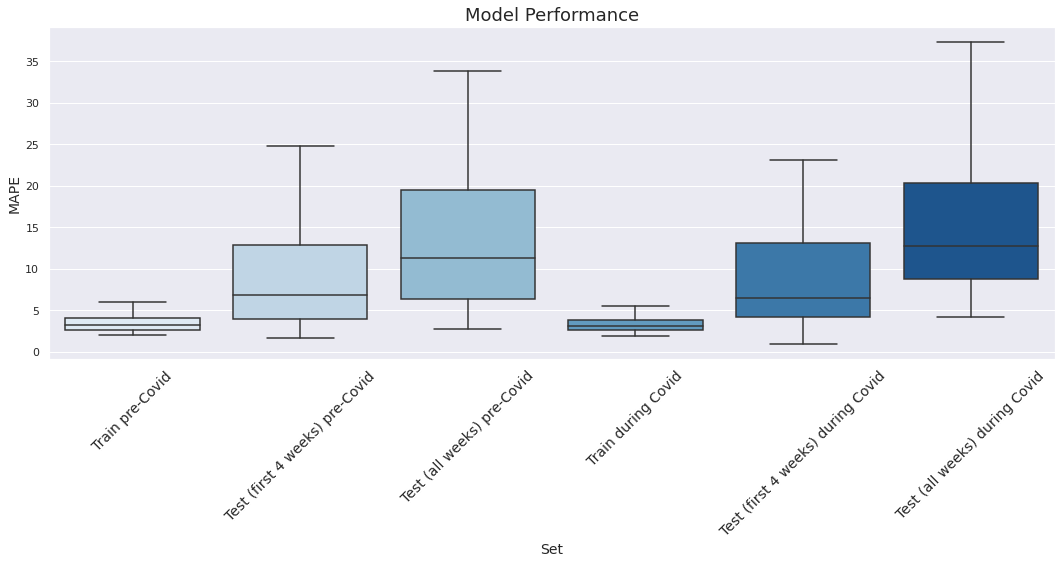

In [11]:
boxplot_data_mape = model_evaluation_df.drop(['categories'], axis = 1).stack().reset_index()
boxplot_data_mape.columns = ['section', 'metric', 'value']
sns.set(font_scale = 1.0)
fig, ax = plt.subplots(figsize = (15, 8))
sns.boxplot(y = 'value', x = 'metric', data = boxplot_data_mape, showfliers = False, ax = ax, palette = 'Blues')
ax.set_title('Model Performance', fontsize = 18)
ax.set_xlabel('Set', fontsize = 14)
ax.set_ylabel('MAPE', fontsize = 14)
ax.set_xticklabels(labels = ['Train pre-Covid', 'Test (first 4 weeks) pre-Covid', 'Test (all weeks) pre-Covid', 
                             'Train during Covid', 'Test (first 4 weeks) during Covid', 'Test (all weeks) during Covid'], 
                   rotation=45,
                   fontsize = 14)
plt.tight_layout()
plt.savefig('/content/drive/My Drive/Datathon Term 3/04 Modeling/Model Performance.png', dpi = 300)

In [12]:
model_evaluation_df.median()

mape_train_pre_covid         3.255290
mape_test_4_pre_covid        6.862787
mape_test_pre_covid         11.294875
mape_train_during_covid      3.105147
mape_test_4_during_covid     6.463291
mape_test_during_covid      12.700404
dtype: float64